# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [3]:
# all import statements needed for the project, for example:

import math
from math import radians, sin, cos, asin, sqrt
import datetime
from datetime import datetime
import keplergl
from keplergl import KeplerGl
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import re
import numpy as np

In [4]:
# any general notebook setup, like log formatting
import warnings
# setting ignore as a parameter
warnings.filterwarnings('ignore') 

In [5]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
_**TODO:** Write some prose that tells the reader what you're about to do here._

In [6]:
def calculate_distance(from_coord, to_coord):
    # calculate the dstance between two coordinates in kilometers
    
    # get the statistics from the imported file 
    pickup_longitude = from_coord['pickup_longitude'].map(radians)
    pickup_latitude = from_coord['pickup_latitude'].map(radians)
    dropoff_longitude = to_coord['dropoff_longitude'].map(radians)
    dropoff_latitude = to_coord['dropoff_latitude'].map(radians)
    
  
    Radius_of_earth = 6378.1
    diff_lon = pickup_longitude - dropoff_longitude
    diff_lat = pickup_latitude - dropoff_latitude
    
    # calculate the result using following equations by converting coordinates to km
    
    #Equations
    part_one = (diff_lat/2).map(sin)**2 + pickup_latitude.map(cos)*dropoff_latitude.map(cos)* (diff_lon/2).map(sin)**2
    part_two =  part_one.map(sqrt).map(asin)
    
    #Final answer
    dist = 2*part_two*Radius_of_earth
    
    return dist

In [7]:
def add_distance_column(dataframe):
    # using the distance calculating function above
    from_coord = dataframe[['pickup_latitude', 'pickup_longitude']]
    to_coord = dataframe[['dropoff_latitude', 'dropoff_longitude']]
    
    #Add a new column called distance to the dataframe
    dataframe['distance'] = calculate_distance(from_coord, to_coord)
    
    return dataframe

### Processing Taxi Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [8]:
def find_taxi_csv_urls():
    # get all the URLs meet the requirements from the given website.
    
    # input the known website
    TAXI_URL = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

    # get the links meet the requirements(for yellow taxi from 2009-01 to 2015-06)
    response = requests.get(TAXI_URL)
    html = response.content
    soup = bs4.BeautifulSoup(html, "html.parser")
    
    # derive all yellow taxi files
    yellow_taxi = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    all_links = [a["href"] for a in yellow_taxi]

    # derive 2009-01 to 2015-06 records for yellow taxi
    pattern = re.compile(
    r"yellow_tripdata_2009-([0-9]{2})|yellow_tripdata_201([0-4])-([0-9]{2})|yellow_tripdata_2015-0([1-6]).parquet"
    )
    
    # create a empty list in order to store the links
    URLs = []

    # using for loop to see whether the URLs match the pattern
    # and add to the list created before if the pattern is matched
    for link in all_links:
        match = pattern.search(link)
        if match:
            URLs.append(match.string)
            
    return URLs

In [9]:
def get_and_clean_month_taxi_data(url):
    # Given URLs to get clean monthly taxi data.
    dirty_taxi = pd.read_parquet(url)
    
    # Cleaning the data
    # To match between columns in different years with same meaning
    dirty_taxi= dirty_taxi.rename(columns = {"tpep_pickup_datetime": "pickup_datetime",
                                "tpep_dropoff_datetime": "dropoff_datetime",
                                "Trip_Pickup_DateTime": "pickup_datetime",
                                "Trip_Dropoff_DateTime": "dropoff_datetime",
                                "Passenger_Count": "passenger_count",
                                "Total_Amt": "total_amount",
                                "Start_Lon": "pickup_longitude",
                                "Start_Lat": "pickup_latitude",
                                "End_Lon": "dropoff_longitude",
                                "End_Lat": "dropoff_latitude",
                                "Tip_Amt": "tip_amount"})
    
    # We only care about data which the number of passenger is greater than 0
    # So in this stage, we only retain the "passenger_count >=1" and rest of data marks as invalid data
    clean_taxi = dirty_taxi[(dirty_taxi["passenger_count"] >= 1)]
    
    # Delete invalid data points with zero total amount 
    clean_taxi = clean_taxi[clean_taxi["total_amount"] != 0]
    
    
    # To illustrate Column("PULocationID" and "DOLocationID") in Coordinates
    taxi_zone = gpd.read_file('taxi_zones.zip')
    taxi_zone = taxi_zone.to_crs(4326)
    taxi_zone["longitude"] = taxi_zone.centroid.x
    taxi_zone["latitude"] = taxi_zone.centroid.y
    
    # Keep Columns that needed to answer questions:
    # We need 'pickup_datetime','dropoff_datetime','tip_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'
        
    # For data after 2010
    # If 'PULocationID' included in the column
    # We need to transfer into coordinates and add to dataframe as a new column
    # Same procedure for 'DOLocationID' for dropoff
    if 'PULocationID' in clean_taxi.columns:
        # First select existed columns needed
        data_taxi = clean_taxi[["pickup_datetime","dropoff_datetime", "tip_amount"]]
        # Create new column to store trasfered data
        data_taxi['pickup_longitude'] = clean_taxi['PULocationID'].map(taxi_zone.centroid.x)
        data_taxi['pickup_latitude'] = clean_taxi['PULocationID'].map(taxi_zone.centroid.y)
        data_taxi['dropoff_longitude'] = clean_taxi['DOLocationID'].map(taxi_zone.centroid.x)
        data_taxi['dropoff_latitude'] = clean_taxi['DOLocationID'].map(taxi_zone.centroid.y)
    else:
        # For data before 2010
        # Select columns we want:
        data_taxi = clean_taxi[['pickup_datetime','dropoff_datetime','tip_amount','pickup_longitude',
                           'pickup_latitude','dropoff_longitude','dropoff_latitude']]
    
    # Drop invalid points with in selected columns
    data_taxi = data_taxi.dropna()
    
    # Remove the pickup and dropoff points outside desired coordinates:
    # (40.560445, -74.242330) and (40.908524, -73.717047).
    data_taxi = data_taxi[(data_taxi['pickup_longitude'] > NEW_YORK_BOX_COORDS[0][1]) & 
                          (data_taxi['pickup_longitude'] < NEW_YORK_BOX_COORDS[1][1]) &
                          (data_taxi['pickup_latitude'] > NEW_YORK_BOX_COORDS[0][0]) &
                          (data_taxi['pickup_latitude'] < NEW_YORK_BOX_COORDS[1][0]) &
                          (data_taxi['dropoff_longitude'] > NEW_YORK_BOX_COORDS[0][1]) & 
                          (data_taxi['dropoff_longitude'] < NEW_YORK_BOX_COORDS[1][1]) &
                          (data_taxi['dropoff_latitude'] > NEW_YORK_BOX_COORDS[0][0]) &
                          (data_taxi['dropoff_latitude'] < NEW_YORK_BOX_COORDS[1][0])]
    
    # Sample monthly data in order to roughly get the same amount of data points 
    # over the given date range for both Taxi data and Uber data.
    # Given 78 months within the range, we need to sample out 200,000/78 data out of the cleaned data
    sample_taxi = data_taxi.sample(n = 2565)
    sample_taxi.set_index(pd.Series(range(2565)), inplace=True)
    
    # Normalize column names
    taxi_data = sample_taxi.rename(columns = {"tpep_pickup_datetime": "pickup_datetime",
                                "tpep_dropoff_datetime": "dropoff_datetime"})
                     
    return taxi_data

In [10]:
def get_and_clean_taxi_data():
    # Using for loop to get and clean data from every month through 2009-01 to 2015-06
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in tqdm(all_csv_urls):
        dataframe = get_and_clean_month_taxi_data(csv_url)
        add_distance_column(dataframe)        
        all_taxi_dataframes.append(dataframe)
        
    # Create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    
    # Normalize the types of content in each column
    taxi_data[['pickup_datetime', 'dropoff_datetime']] = taxi_data[['pickup_datetime', 'dropoff_datetime']].apply(pd.to_datetime)
    taxi_data.iloc[:, 2:7] = taxi_data.iloc[:, 2:7].astype("float64")
    
    return taxi_data

### Processing Uber Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [16]:
def add_distance_column(dataframe):
    #step4: import a new column "distance" into the dataframe with the result of step3.
    from_coord = dataframe[["pickup_latitude","pickup_longitude"]]
    to_coord = dataframe[["dropoff_latitude","dropoff_longitude"]]
    
    dataframe["distance"] = calculate_distance(from_coord, to_coord)
    dataframe["distance"] = dataframe["distance"].astype("float32")
    
    return dataframe

In [17]:
def load_and_clean_uber_data(csv_file):
    uber = pd.read_csv(csv_file)
    
    # Remove invalid passenger count 
    uber = uber[(uber["passenger_count"] >= 1)]
    
    # Pick useful columns
    uber_new = uber[["pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]]
    
    # Normalize the datetime
    uber_new["pickup_datetime"] = uber_new["pickup_datetime"].astype("datetime64[ns]")

    # Normalize the columns with float content
    uber_new.iloc[:, 1:5] = uber_new.iloc[:, 1:5].astype("float64")
    
    # Remove trips that start or end outside the designated coordinate box 
    # Make sure that the values of longitude and latitude for 
    # pickup and dropoff are in the box 
    uber_new = uber_new[(uber_new['pickup_longitude'] > NEW_YORK_BOX_COORDS[0][1]) & 
                          (uber_new['pickup_longitude'] < NEW_YORK_BOX_COORDS[1][1]) &
                          (uber_new['pickup_latitude'] > NEW_YORK_BOX_COORDS[0][0]) &
                          (uber_new['pickup_latitude'] < NEW_YORK_BOX_COORDS[1][0]) &
                          (uber_new['dropoff_longitude'] > NEW_YORK_BOX_COORDS[0][1]) & 
                          (uber_new['dropoff_longitude'] < NEW_YORK_BOX_COORDS[1][1]) &
                          (uber_new['dropoff_latitude'] > NEW_YORK_BOX_COORDS[0][0]) &
                          (uber_new['dropoff_latitude'] < NEW_YORK_BOX_COORDS[1][0])]

    return uber_new 

In [18]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    
    return uber_dataframe

### Processing Weather Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [19]:
def clean_month_weather_data_hourly(csv_file):
    weather_dirty = pd.read_csv(csv_file)
    
    # Only pick useful columns
    weather_clean = weather_dirty[["DATE", "HourlyPrecipitation", "HourlyWindSpeed"]]
    
    # Normalize the datetime column
    weather_clean["DATE"] = weather_clean["DATE"].astype("datetime64[ns]")
    weather_clean["HourlyPrecipitation"] = pd.to_numeric(weather_clean["HourlyPrecipitation"], errors='coerce')
    weather_clean["HourlyWindSpeed"] = pd.to_numeric(weather_clean["HourlyWindSpeed"], errors='coerce')
    
    # Normalize the hourlypercipitation column   
    # Calculate the mean of hourly precipitation by skipping NaN values
    mean_hourlypercipitation = weather_clean["HourlyPrecipitation"].notna().mean()  
    
    # Replace the "T" values by 0 and NaN values by mean(calculated above)
    weather_clean["HourlyPrecipitation"] = weather_clean["HourlyPrecipitation"].replace(["T", np.nan], [0, mean_hourlypercipitation])
    
    # Normalize the hourlywindspeed column
    # Calculate the mean of hourly windspeed by skipping NaN values
    mean_hourlywindspeed = weather_clean["HourlyWindSpeed"].notna().mean()   
    
    # Replace NaN values by mean(calculated above)
    weather_clean["HourlyWindSpeed"] = weather_clean["HourlyWindSpeed"].replace(np.nan, mean_hourlywindspeed)
    
    # Nomarlize the float columns
    weather_clean[["HourlyPrecipitation", "HourlyWindSpeed",]] = weather_clean[["HourlyPrecipitation", "HourlyWindSpeed",]].astype("float64")
    
    return weather_clean

In [20]:
def clean_month_weather_data_daily(csv_file):
    # Get the cleaned WEATHER data in DAILIY 
    weather_hourly = clean_month_weather_data_hourly(csv_file)
    
    # Change the column name for daily use
    weather_daily = pd.DataFrame().assign(Precipitation=weather_hourly['HourlyPrecipitation'], Windspeed=weather_hourly['HourlyWindSpeed'])
    # Change the fitst column to data and calculate mean as the daily statistics
    weather_daily["DATE"] = weather_hourly["DATE"].dt.date
    
    # There is a column originally contains the file called "DailyWindSpeed",
    # but the Windspeed calculated using mean of DailyWindSpeed contains more
    # information than the originaly one,
    # we choose to use Windspeed calculated by np.mean and percipitation.
    weather_daily = weather_daily.groupby('DATE').agg({'Precipitation': np.mean, 'Windspeed': np.mean})
    
    # Add a new index column
    weather_daily = weather_daily.reset_index()
    return weather_daily

In [21]:
def load_and_clean_weather_data():
    # Create empty list to store value for both hourly weather data as well as daily's 
    hourly_dataframes = []
    daily_dataframes = []
    
    weather_csv_files = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv",
                        "2012_weather.csv", "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # Create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [22]:
from tqdm import tqdm

In [23]:
taxi_data = get_and_clean_taxi_data()

100%|█████████████████████████████████████████| 78/78 [1:31:39<00:00, 70.50s/it]


In [25]:
uber_data = get_uber_data()

In [26]:
hourly_data, daily_data = load_and_clean_weather_data()

## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [27]:
engine = db.create_engine(DATABASE_URL)

In [76]:
# CREATE 4 tables in SQL
# Each includes columns we need

HOURLY_WEATHER_SCHEMA = """
        CREATE TABLE IF NOT EXISTS hourly_weather
        (
            id INTEGER PRIMARY KEY,
            DATE DATE,
            HourlyPrecipitation FLOAT,
            HourlyWindSpeed FLOAT
            );
"""

DAILY_WEATHER_SCHEMA = """
         CREATE TABLE IF NOT EXISTS daily_weather
        (
            id INTEGER PRIMARY KEY,
            DATE DATE,
            Precipitation FLOAT,
            Windspeed FLOAT
            );
"""

TAXI_TRIPS_SCHEMA = """

        CREATE TABLE IF NOT EXISTS taxi_trips
        (
            id INTEGER PRIMARY KEY,
            pickup_datetime DATE,
            dropoff_datetime DATE,
            tip_amount FLOAT,
            pickup_longitude FLOAT,
            pickup_latitude FLOAT,
            dropoff_longitude FLOAT,
            dropoff_latitude FLOAT,
            distance FLOAT
            
        );
        
"""

UBER_TRIPS_SCHEMA = """
    CREATE TABLE IF NOT EXISTS uber_trips
        (
            id INTEGER PRIMARY KEY,
            pickup_datetime DATE,
            pickup_longitude FLOAT,
            pickup_latitude FLOAT,
            dropoff_longitude FLOAT,
            dropoff_latitude FLOAT,
            distance FLOAT
            
        );
"""

In [77]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [78]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [79]:
def write_dataframes_to_table(table_to_df_dict):
    for table, dataframe in table_to_df_dict.items():
        dataframe.to_sql(table, engine, if_exists='append', index=False)

In [80]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_data,
    "daily_weather": daily_data,
}

In [81]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [51]:
def write_query_to_file(query, outfile):
    with open(QUERY_DIRECTORY + '/' + outfile, "w") as f:
        f.write(query)

### Query 1

_**TODO:** From 2009.1 to 2015.6, we aim to find out hours of the day that are most popular to take a YellowTaxi._



In [52]:
# We use taxi_trips table to select only hours in "pickup_datetime" Column and sum the count in each hour
# Ordered by highest count to lowest count
QUERY_1 = """
    SELECT strftime('%H', pickup_datetime) as hour_of_day, COUNT(*) AS frequency
    FROM taxi_trips
    GROUP BY hour_of_day
    ORDER BY frequency DESC;
"""

In [53]:
# Only pick the hour that is most popular to take Taxi
# Result shows that the most popular time to take Taxi is 7 p.m.
engine.execute(QUERY_1).fetchall()[0]

('19', 12484)

In [56]:
# Write into file
write_query_to_file(QUERY_1, "Taxi_popular_hour.sql")

### Query 2

_**TODO:** From 2009.1 to 2015.6, we aim to find out hours of the day that are most popular to take a UBER._


In [57]:
# We use uber_trips table to select only hours in "pickup_datetime" Column and sum the count in each hour
# Ordered by highest count to lowest count
QUERY_2 = """
    SELECT strftime('%w', pickup_datetime) as day_of_week, COUNT(*) AS frequency
    FROM uber_trips
    GROUP BY day_of_week
    ORDER BY frequency DESC;
"""

In [58]:
# Only pick the hour that is most popular to take Uber
# Result shows that the most popular time to take Taxi is 5 a.m.
engine.execute(QUERY_2).fetchall()[0]

('5', 331370)

In [60]:
# Write into file
write_query_to_file(QUERY_2, "Uber_popular_day.sql")

### Query 3

**TODO:** We aim to calculate 95% percentile of distance traveled for all hired trips during July 2013

In [95]:
# Step1: Union the distance in 'taxi_trips' and 'uber_trips' tables as a new table called 'hired_trips' during July 2013
# Step2: Ordering the distance in 'hired_trips' table through longest distance to shortest
# Step3: Only pick the longest 5 percentile data by limiting

QUERY_3 = """ WITH hired_trips AS(
        SELECT
            distance
        FROM taxi_trips
        WHERE pickup_datetime BETWEEN '2013-07-01 00:00:00' AND '2013-07-31 24:00:00'
        
        UNION ALL
        
        SELECT 
            distance
        FROM uber_trips
        
        WHERE pickup_datetime BETWEEN '2013-07-01 00:00:00' AND '2013-07-31 24:00:00')
        
        
        SELECT distance
        FROM hired_trips
        ORDER BY distance DESC
        LIMIT  (SELECT 
                COUNT(*) 
                FROM hired_trips) 
                * 5/100      
        """

In [96]:
# Since we selected the longest 5 percentile and we need the 95% percentile
# we should choose the last one in the list
engine.execute(QUERY_3).fetchall()[-1]

(25.213462829589844,)

In [97]:
# Write into file
write_query_to_file(QUERY_3, "nintyfive_percentile_distance.sql")

### Query 4

**TODO:** We aim to find out 10 days in 2009 with the highest number of hired rides, and the average distance for each day.

In [98]:
# Step1: Union the distance and pickup_datetime in 'taxi_trips' and 'uber_trips' tables as a new table called 'hired_trips'
#        in 2009
# Step2: Calculate average distance in each day 
# Step3: The data should be ordered by count of hired_trips from highest to lowest 
# Step4: limit into 10 days

QUERY_4 = """ WITH hired_trips AS(
        SELECT
            distance,
            pickup_datetime
        FROM taxi_trips
        WHERE pickup_datetime BETWEEN '2009-01-01 00:00:00' AND '2009-12-31 24:00:00'
        
        UNION ALL
        
        SELECT 
            distance,
            pickup_datetime
        FROM uber_trips
        
        WHERE pickup_datetime BETWEEN '2009-01-01 00:00:00' AND '209-12-31 24:00:00')
        
        
        SELECT DATE(pickup_datetime) AS date, 
                AVG(distance) AS avgdistance,
                count(*) as number_of_rides
                
        FROM hired_trips
        GROUP BY date
        ORDER BY number_of_rides DESC
        LIMIT 10 
        
        
        """

In [99]:
# Find out highest number of hired rides in 10 days in 2009
engine.execute(QUERY_4).fetchall()

[('2009-04-18', 3.2839115309717455, 341),
 ('2009-09-25', 3.230270602841334, 332),
 ('2009-12-04', 2.8165812350561974, 331),
 ('2009-11-13', 2.6023554659428254, 321),
 ('2009-09-16', 2.9993398456640965, 318),
 ('2009-12-19', 3.1394177942542703, 314),
 ('2009-02-13', 3.4081405062424195, 314),
 ('2009-01-31', 2.753383362796276, 314),
 ('2009-07-23', 3.1894055169119757, 312),
 ('2009-07-30', 3.1967717631977544, 311)]

In [100]:
# Write into file
write_query_to_file(QUERY_4, "highest_rides_ten_avgdistance.sql")

### Query 5

**TODO:** Find out 10 days in 2014 were the windiest on average, and hired trips were made in such days.

In [101]:
# Step1: Change date in %Y-%m-%d format
# Step2: Union 'taxi_trips' table and 'uber_trips' with Column 'date' and 'number_of_rides' into a table called 'hired_trips' from 2014
# Step3: Inner join 'daily_weather' table with 'hired_trips' table on 'date' column
# Step4: the date should be ordered by windspeed through highest to lowest 
# Step5: Retain the first 10 days

QUERY_5 = """
        WITH hired_trips AS(
        SELECT
            DATE(pickup_datetime) AS DATE,
            COUNT(*) as number_of_rides
        FROM taxi_trips
        WHERE pickup_datetime BETWEEN '2014-01-01 00:00:00' AND '2014-12-31 24:00:00'
        GROUP BY DATE
        
        UNION ALL
        
        SELECT 
            DATE(pickup_datetime) AS DATE,
            COUNT(*) as number_of_rides
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2014-01-01 00:00:00' AND '2014-12-31 24:00:00'
        GROUP BY DATE
        )
              
        SELECT DATE(daily_weather.DATE) as D,
                hired_trips.number_of_rides
              
        FROM daily_weather
            INNER JOIN hired_trips
                ON daily_weather.DATE = hired_trips.DATE
        WHERE D BETWEEN '2014-01-01' AND '2015-01-01'
        GROUP BY D
        ORDER BY daily_weather.WINDSPEED DESC
        LIMIT 10 
        """

In [102]:
# Find out the windest 10 days in 2014 with number of hired trips
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 180),
 ('2014-01-07', 192),
 ('2014-01-02', 134),
 ('2014-02-13', 114),
 ('2014-03-29', 210),
 ('2014-12-07', 168),
 ('2014-12-09', 176),
 ('2014-12-08', 154),
 ('2014-03-26', 154),
 ('2014-01-03', 116)]

In [42]:
write_query_to_file(QUERY_5, "widest_trips.sql")

### Query 6

TODO: During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [106]:
# Step1: Use strftime function to transfer values in 'date' into 24 hours separately in date
# Step2: Count number of rides group by each hour from 2012-10-22 to 2012-10-30
# Step3: Union 'taxi_trips' table and 'uber_trips'to trips with 'hour_of_day' and 'number_of_rides' Column
# Step4: Left join 'hourly_weather' table with 'trips' table 
# Step5: Group ('number_of_rides', 'precipitation', and 'windspeed') by each hours from 2012-10-22 to 2012-10-30


QUERY_6 = """
        WITH trips AS (
                SELECT strftime('%Y-%m-%d %H:00:00:00',pickup_datetime) as hour_of_day,
                COUNT(*) AS number_of_rides
                FROM taxi_trips
                WHERE pickup_datetime BETWEEN '2012-10-22 00:00:00' AND '2012-10-30 24:00:00'
                GROUP BY hour_of_day
                
                UNION ALL
                
                SELECT strftime('%Y-%m-%d %H:00:00:00',pickup_datetime) as hour_of_day,
                COUNT(*) AS number_of_rides
                FROM uber_trips
                WHERE pickup_datetime BETWEEN '2012-10-22 00:00:00' AND '2012-10-30 24:00:00'
                GROUP BY hour_of_day
                )
                
                SELECT  strftime('%Y-%m-%d %H:00:00:00', hourly_weather.DATE) as hours,
                        trips.number_of_rides,
                        hourly_weather.HourlyPrecipitation as precipitation,
                        hourly_weather.HourlyWindSpeed as windspeed
                        
                    FROM hourly_weather
                        LEFT JOIN trips
                            ON hours = hour_of_day
                WHERE hours BETWEEN '2012-10-22 00:00:00' AND '2012-10-30 24:00:00'
                GROUP BY hours
"""

In [107]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00:00:00:00', 2, 0.0, 7.0),
 ('2012-10-22 01:00:00:00', None, 0.0, 5.0),
 ('2012-10-22 02:00:00:00', 1, 0.0, 7.0),
 ('2012-10-22 03:00:00:00', 1, 0.0, 0.0),
 ('2012-10-22 04:00:00:00', None, 0.0, 0.0),
 ('2012-10-22 05:00:00:00', 1, 0.0, 0.0),
 ('2012-10-22 06:00:00:00', 3, 0.0, 5.0),
 ('2012-10-22 07:00:00:00', 4, 0.0, 3.0),
 ('2012-10-22 08:00:00:00', 1, 0.0, 3.0),
 ('2012-10-22 09:00:00:00', 5, 0.0, 5.0),
 ('2012-10-22 10:00:00:00', 3, 0.0, 0.9547325102880658),
 ('2012-10-22 11:00:00:00', 8, 0.0, 0.9547325102880658),
 ('2012-10-22 12:00:00:00', 4, 0.0, 11.0),
 ('2012-10-22 13:00:00:00', 8, 0.0, 0.9547325102880658),
 ('2012-10-22 14:00:00:00', 1, 0.0, 7.0),
 ('2012-10-22 15:00:00:00', 1, 0.0, 6.0),
 ('2012-10-22 16:00:00:00', 6, 0.0, 3.0),
 ('2012-10-22 17:00:00:00', 4, 0.0, 7.0),
 ('2012-10-22 18:00:00:00', 8, 0.0, 5.0),
 ('2012-10-22 19:00:00:00', 2, 0.0, 5.0),
 ('2012-10-22 20:00:00:00', 4, 0.0, 3.0),
 ('2012-10-22 21:00:00:00', 1, 0.0, 0.0),
 ('2012-10-22 22:00:00:0

In [108]:
write_query_to_file(QUERY_5, "every_hour_trips.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization 1

_**TODO:** From 2009.1 to 2015.6, we aim to visualize the number of trips taken among 24 hours of the day for YellowTaxi._

In [164]:
def plot_taxi_trips(dataframe):
    # using dataframe.plot to plot the table
    # giving the title, x label, y label needed for the graph
    plot_title = "The Number of Taxi Trips Per Hour"
    plot_xlabel ="Hour of the Day"
    plot_ylabel = "Number of Trips"
    # provide the x and y and the kind the graph needed as argument for the function
    c = plt.get_cmap('tab20c').colors
    dataframe.plot(x = "hour_of_day", y = "frequency", title = plot_title, xlabel = plot_xlabel, ylabel = plot_ylabel, kind = "bar", color = c)

In [47]:
def get_data_for_taxi_trips():
    # get the dataframe from part3_query1
    dataframe = pd.read_sql_query(QUERY_1, engine)
    # sort the dataframe in order to have a better plot
    sorted_dataframe = dataframe.sort_values(by = "hour_of_day")
    return sorted_dataframe

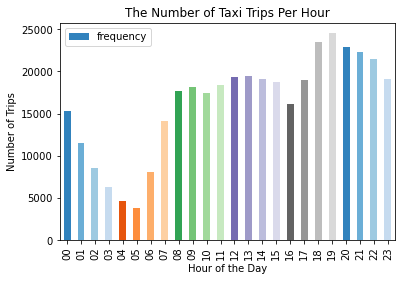

In [165]:
taxi_trips_dataframe = get_data_for_taxi_trips()
plot_taxi_trips(taxi_trips_dataframe)

### Visualization 2

_**TODO:** We aim to show the average distance traveled per month(regardless of the year) using combined statistics from Taxi and Uber. Also, we would include 90% confidence interval around the mean._

In [162]:
def plot_avg_distance(dataframe):
    # using dataframe.plot to plot the table
    # giving the title, x label, y label needed for the graph
    plot_title = "Average Distance Traveled Per Month"
    plot_xlabel ="Month of the Year"
    plot_ylabel = "Average Distance Traveled"
    # provide the x, y, 90% CI and the kind the graph needed as argument for the function
    c = plt.get_cmap('tab20c').colors
    dataframe.plot(use_index = True, y = "avgdistance", yerr = "CI", title = plot_title, xlabel = plot_xlabel, ylabel = plot_ylabel, kind = "bar", color = c)

In [50]:
def get_data_for_avg_distance():
    # get the dataframe from a new query 
    # which generate the average distance traveled per month
    query_avg_distance = """
    WITH hired_trips AS(
        SELECT 
            SUM(distance) as d,
            pickup_datetime
        FROM uber_trips
        GROUP BY  pickup_datetime
        
        UNION
        
        SELECT
            SUM(distance) as d,
            pickup_datetime
        FROM taxi_trips
        GROUP BY  pickup_datetime)

        
        
        SELECT strftime('%m', pickup_datetime) as m,
               AVG(dis) AS avgdistance,
               SQRT(AVG(dis*dis) - AVG(dis)*AVG(dis)) AS stddistance
        FROM (
            SELECT 
                sum(d) as dis,
                pickup_datetime
                
                FROM hired_trips
                GROUP BY strftime('%Y-%m', pickup_datetime)
        )
        
        GROUP BY m       
    """
    dataframe = pd.read_sql_query(query_avg_distance, engine)
    # equation for calculating 90% CI as a new column
    # using mean and standard deviation 
    dataframe["CI"] = 2 * (dataframe["stddistance"]/sqrt(dataframe.shape[0]) * 1.645)
    return dataframe

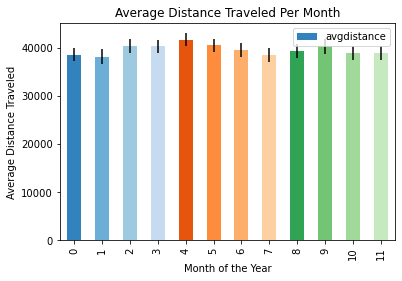

In [163]:
avg_dist_dataframe = get_data_for_avg_distance()
plot_avg_distance(avg_dist_dataframe)

### Visualization 3

_**TODO:** We aim to find the most popular day of the week for drop offs for LGA, JFK, and EWR._

In [160]:
def plot_airports(dataframe):
    # using dataframe.plot to plot the table
    # giving the title, x label, y label needed for the graph
    plot_title = "Average Distance Traveled Per Month"
    plot_xlabel ="Month of the Year"
    plot_ylabel = "Average Distance Traveled"
    # provide the x and y and the kind the graph needed as argument for the function
    c = plt.get_cmap('tab20c').colors
    dataframe.plot(y=["LGA", "JFK", "EWR"], kind="bar", use_index=True, color = (c[6],c[12],c[18]))

In [53]:
def get_data_for_airports():
    # get the dataframe from a new query 
    # which generate the drop offs in LGA, JFK, and EWR.
    
    # first define the dropoff_longitude and dropoff_latitude within the LGA, JFK, and EWR.
    LGA = [[-73.889751, -73.854561], [40.765652, 40.786261]]
    JFK = [[-73.823427, -73.747209], [40.619788, 40.666679]]
    EWR = [[-74.184328, -74.151241], [40.668766, 40.709898]]
    airport = [LGA, JFK, EWR]
    
    # set up a dataframe to store the number of trips for each airport
    column_names = ["LGA", "JFK", "EWR"]
    dataframe = pd.DataFrame(index = [i for i in range(1,8)])
    dataframe.index.name = "Month"
    
    # use for loop to walk through every airport
    # 
    for i in [0, 1, 2]:
        query_popular_day = f"""
            WITH trips AS(
                SELECT
                 dropoff_longitude, dropoff_latitude,
                 strftime('%w', pickup_datetime) AS DAY 
                FROM uber_trips
                 
                UNION
                
                SELECT
                 dropoff_longitude, dropoff_latitude,
                 strftime('%w', pickup_datetime) AS DAY 
                FROM taxi_trips)
            SELECT
                DAY, COUNT (*) AS num_trips
            FROM trips
            WHERE dropoff_longitude BETWEEN {airport[i][0][0]} AND {airport[i][0][1]} AND dropoff_latitude BETWEEN {airport[i][1][0]} AND {airport[i][1][1]}
            GROUP BY DAY
        """
        num = engine.execute(query_popular_day).fetchall()
        num_airport = [x[1] for x in num]
        dataframe[column_names[i]] = num_airport
    return dataframe

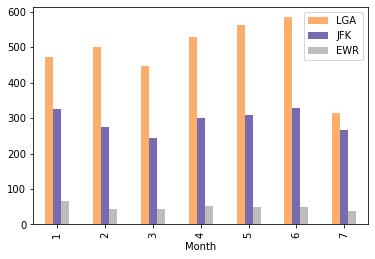

In [161]:
num_for_airports = get_data_for_airports()
plot_airports(num_for_airports)

### Visualization 4

_**TODO:** We aim to create a heatmap of all hired trips over a map of the area._

In [114]:
def plot_trips_heatmap(dataframe):
    # To illustrate Column("PULocationID" and "DOLocationID") in Coordinates
    taxi_zone = gpd.read_file('taxi_zones.zip')
    taxi_zone = taxi_zone.to_crs(4326)
    taxi_zone["longitude"] = taxi_zone.centroid.x
    taxi_zone["latitude"] = taxi_zone.centroid.y
    
    # Get a new column named "zone" as the sum of 
    # absolute value of "longitude" and "latitude"
    taxi_zone["zone"] = taxi_zone["latitude"] + abs(taxi_zone["longitude"])
    
    # Derive pickup statistics from given dataframe
    pickup_trips = dataframe
    
    # Get a new column named "zone" as the sum of 
    # absolute value of "longitude" and "latitude"
    pickup_trips["zone"] = pickup_trips.iloc[:,0] + abs(pickup_trips.iloc[:,1])
    
    # Sort two dataframes in order to help merging in the next step
    taxi_zone = taxi_zone.sort_values(by = "zone")
    pickup_trips = pickup_trips.sort_values(by = "zone")
    
    # Merge two tables together using the "zone" column
    trips_zone = pd.merge_asof(pickup_trips, taxi_zone, left_on=["zone"],right_on=["zone"])
    trips_zone = trips_zone.dropna()
    
    # Group by "LocationID" to count the number of trips in each zone
    # and given the number of frequency as a new column "count"
    taxi_zone['count'] = trips_zone.groupby("LocationID").count()['zone']
    
    # Plot the heatmap 
    taxi_zone.plot(column='count', cmap='coolwarm', legend=False)
    plt.axis('off')
    plt.show()

In [119]:
def get_data_for_heatmap():
    query_pickup_heatmap = """
            WITH hired_trips AS(
            SELECT pickup_latitude, pickup_longitude
            FROM taxi_trips
            
            UNION
            
            SELECT pickup_latitude, pickup_longitude
            FROM uber_trips
            )
            
            SELECT *
            FROM hired_trips
            GROUP BY pickup_latitude, pickup_longitude
    """ 
    
    query_dropoff_heatmap = """
            WITH hired_trips AS(
            SELECT dropoff_latitude, dropoff_longitude
            FROM taxi_trips
            
            UNION
            
            SELECT dropoff_latitude, dropoff_longitude
            FROM uber_trips
            )
            
            SELECT *
            FROM hired_trips
            GROUP BY dropoff_latitude, dropoff_longitude
    """ 
    df_pickup = pd.read_sql_query(query_pickup_heatmap, engine)
    df_dropoff = pd.read_sql_query(query_dropoff_heatmap, engine)
    return df_pickup, df_dropoff

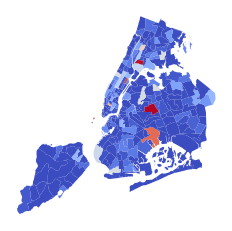

In [120]:
# plot heatmap for pickup trips
pickup_trips = get_data_for_heatmap()[0]
plot_trips_heatmap(pickup_trips)

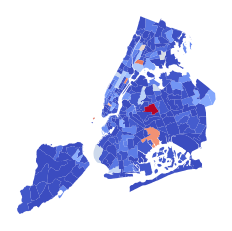

In [121]:
# plot heatmap for dropoff trips
dropoff_trips = get_data_for_heatmap()[1]
plot_trips_heatmap(dropoff_trips)

### Visualization 5

_**TODO:** We aim to create a scatter plot compares tip amount versus distance for Taxi rides._

In [139]:
def plot_tip_dist(dataframe):
    # provide dataframe to plot
    colors = np.random.rand(len(dataframe))
    plt.scatter(dataframe["tip_amount"], dataframe["distance"], c=colors)
    # set title and labels
    plt.title("Tip Amount Versus Distance for Taxi Trips")
    plt.xlabel("Tip Amount")
    plt.ylabel("Distance")

In [131]:
def get_tip_dist():
    query_tip_dist = """
            SELECT tip_amount, distance
            FROM taxi_trips
    """
    dataframe = pd.read_sql_query(query_tip_dist, engine)
    
    # remove outliers in order to have a better scatter plot
    # which are trips with tip amount lager than 30
    # and distance larger than 50
    dataframe = dataframe[dataframe["tip_amount"] < 30]
    dataframe = dataframe[dataframe["distance"] < 50]
    return dataframe

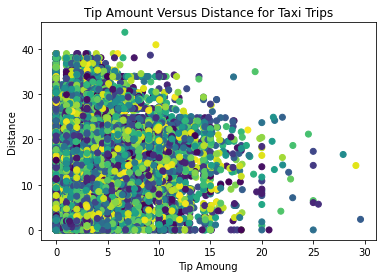

In [140]:
tip_dist = get_tip_dist()
plot_tip_dist(tip_dist)

### Visualization 6

_**TODO:** We aim to create a scatter plot compares tip amount versus precipitation amount for Yellow Taxi rides._

In [92]:
def plot_tip_precipitation(dataframe):
    # provide dataframe to plot
    colors = np.random.rand(len(dataframe))
    # create a scatter plot for tip amount versus precipitation
    # using given dataframe
    plt.scatter(dataframe["tip_amount"], dataframe["Precipitation"], c=colors)
    # set title and labels
    plt.title("Tip Amount Versus Precipitation for Yellow Taxi Rides")
    plt.xlabel("Tip Amount")
    plt.ylabel("Precipitation")

In [93]:
def get_tip_precipitation():
    # get the dataframe with only two columns:
    # tip_amount(from taxi_trips) and Precipitation(from daily_weather)
    # for the same day
    query_tip_precipitation = """
            SELECT daily_weather.DATE, taxi_trips.tip_amount, daily_weather.Precipitation
            FROM taxi_trips
            INNER JOIN daily_weather
                ON daily_weather.DATE = DATE(taxi_trips.pickup_datetime)
            GROUP BY DATE
    """
    # Since there isn't any significant outlier that impact the plot,
    # we do not consider drop any values from the dataframe
    dataframe = pd.read_sql_query(query_tip_precipitation, engine)
    return dataframe

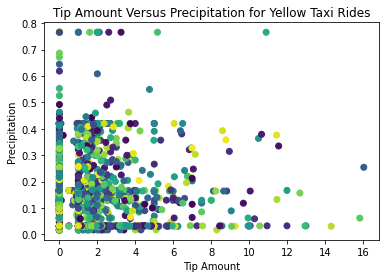

In [94]:
tip_precipitation = get_tip_precipitation()
plot_tip_precipitation(tip_precipitation)